In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from loguru import logger
from PIL import Image
# from torchvision.transforms import ToTensor
from hcmus.core import appconfig
from hcmus.lbs import LabelStudioConnector
# from hcmus.data import TorchDataset
from hcmus.models import kNNSearchModel, kNNSearchConfig
from hcmus.utils import viz_utils

torch_device = "cpu"
lsb_connector = LabelStudioConnector(
    url=appconfig.LABEL_STUDIO_URL,
    api_key=appconfig.LABEL_STUDIO_API_KEY,
    project_id=appconfig.LABEL_STUDIO_PROJECT_MAPPING["train"],
    temp_dir=appconfig.LABEL_STUDIO_TEMP_DIR.joinpath("train")
)
# lsb_dataset = TorchDataset(lsb_connector, device=torch_device)

2025-04-22 21:14:49.929 | INFO     | hcmus.core.appconfig:<module>:7 - Load DotEnv: True
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def process_images_labels(lsb_connector: LabelStudioConnector):
    tasks = lsb_connector.get_tasks(1, 100)
    labels_dict = lsb_connector.extract_labels(tasks)
    idx_to_str = {v: k for k, v in labels_dict.items()}
    image_dataset = lsb_connector.download_dataset(tasks, labels_dict)
    unknown_label_idx = labels_dict["unknown"]
    merged_labels = []
    merged_images = []
    for item in image_dataset:
        try:
            image_path = item["image"]
            raw_image = Image.open(image_path)
            target = item["target"]
            for label in target["labels"]:
                if label == unknown_label_idx and len(target["labels"]) == 1:
                    logger.warning("Image with only unknown label, skipped.")
                    continue
                else:
                    merged_labels.append(idx_to_str[int(label)])
                    merged_images.append(raw_image)
                    break
        except Exception as e:
            logger.error(f"Error processing image: {image_path}, error: {e}")
            continue

    return merged_images, merged_labels

In [4]:
images, labels = process_images_labels(lsb_connector)

2025-04-22 21:14:53.024 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:116 - Page size is too large, only 1640 tasks available.
Loading tasks: 100%|██████████| 17/17 [00:04<00:00,  3.73it/s]
2025-04-22 21:15:35.193 | WARNING  | __main__:process_images_labels:16 - Image with only unknown label, skipped.
2025-04-22 21:15:35.194 | WARNING  | __main__:process_images_labels:16 - Image with only unknown label, skipped.
2025-04-22 21:15:35.195 | WARNING  | __main__:process_images_labels:16 - Image with only unknown label, skipped.
2025-04-22 21:15:35.197 | WARNING  | __main__:process_images_labels:16 - Image with only unknown label, skipped.


In [5]:
model_config = kNNSearchConfig(
    images=images,
    labels=labels,
    box_threshold=0.4,
    label_threshold=65
)

In [6]:
search_model = kNNSearchModel(model_config)

/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Building index...: 100%|██████████| 1636/1636 [00:24<00:00, 67.72it/s]


In [13]:
search_model._config.label_threshold = 68
search_model._config.box_threshold = 0.4

2025-04-22 21:16:28.730 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:116 - Page size is too large, only 372 tasks available.
Loading tasks:  50%|█████     | 2/4 [00:01<00:01,  1.76it/s]


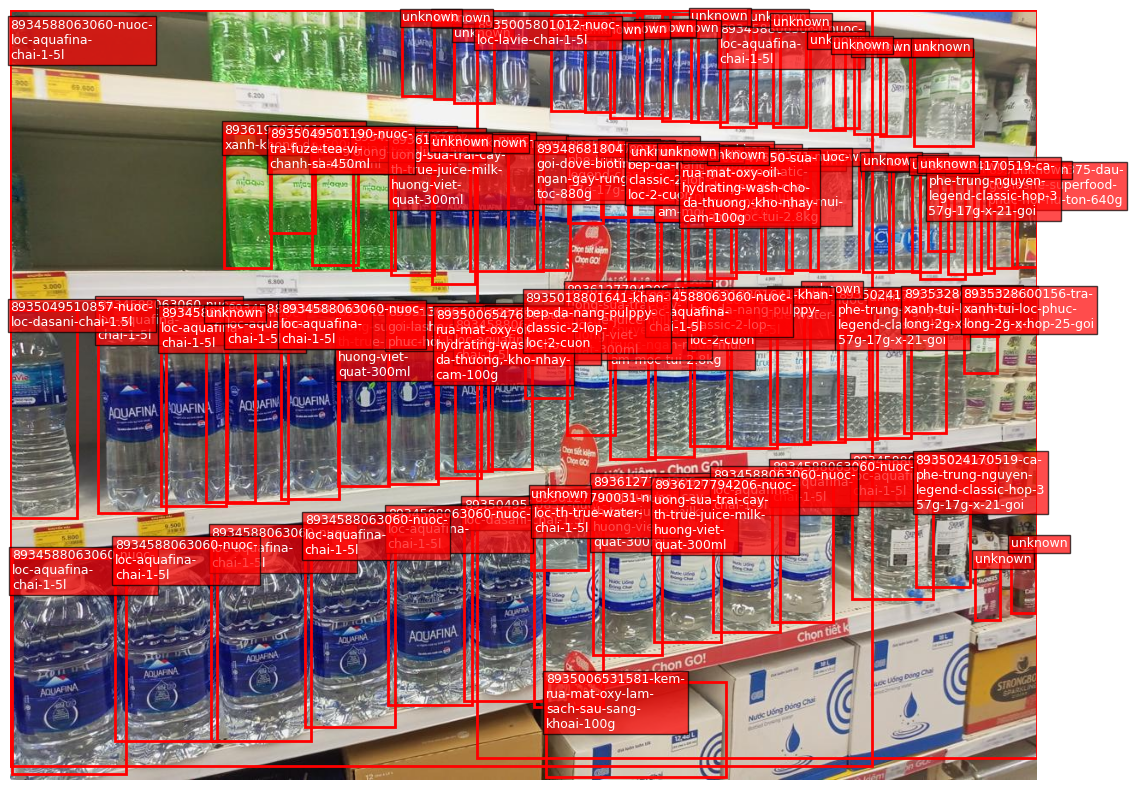

In [14]:
val_connector = LabelStudioConnector(
    url=appconfig.LABEL_STUDIO_URL,
    api_key=appconfig.LABEL_STUDIO_API_KEY,
    project_id=appconfig.LABEL_STUDIO_PROJECT_MAPPING["validation"],
    temp_dir=appconfig.LABEL_STUDIO_TEMP_DIR.joinpath("validation")
)
tmp_tasks = val_connector.get_tasks(1, 100)
tmp_labels_dict = val_connector.extract_labels(tmp_tasks)
tmp_dataset = val_connector.download_dataset(tmp_tasks, tmp_labels_dict)

tmp = Image.open(tmp_dataset[0]["image"])
tmp_result = search_model.predict(tmp)
tmp_boxes = [x.box for x in tmp_result]
tmp_labels = [x.label for x in tmp_result]
viz_utils.draw_boxes(tmp, tmp_boxes, tmp_labels)